In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

In [2]:
PREDICTIONS_PATH = 'C:\\Users\\Dell\\Desktop\\CV Projects\\Histopathologic Cancer Detection/predictions'

In [3]:
os.listdir(PREDICTIONS_PATH)

['densenet169_preds.csv',
 'densenet201_preds.csv',
 'resnet101_preds.csv',
 'resnet50_preds.csv']

In [4]:
# Check the predictions csv file of DenseNet169
pd.read_csv(PREDICTIONS_PATH + '/densenet169_preds.csv').head()

,id,label,prediction
0,2d444f24aaeb77d5f8dd1d9e3c90c04e8c4c1fd0,0,0.000362
1,76a21d7d94abc035ec9b61f199699fcf5372bd15,1,0.956202
2,297956b5014d2d26af2ee53f64123cd3dc2af263,1,0.999992
3,76260356263148fcf00426dfcfbd218d9dfa3e58,0,0.000106
4,cc0c031df0fbde96d4520d68568ba390bdd40c6f,1,0.999043


In [5]:
# Read the csv file of the predictions of all the neural networks and put them in a list

combined_predictions = [
    pd.read_csv(PREDICTIONS_PATH + '/' + pred_file) for pred_file in os.listdir(PREDICTIONS_PATH)
]

In [6]:
x = np.zeros((len(combined_predictions[0]), len(os.listdir(PREDICTIONS_PATH))))

for k in range(len(os.listdir(PREDICTIONS_PATH))):
    x[:, k] = combined_predictions[k].prediction.values

target = combined_predictions[0].label.values

In [7]:
network_names = ['DenseNet169', 'DenseNet201', 'ResNet101', 'ResNet50']

In [8]:
sensitivity_scores = []
specificity_scores = []
auc_scores = []

for k in range(x.shape[1]):
    print('Computing scores for {}...'.format(network_names[k]))
    predictions = x[:, k]
    prediction_labels = [1 if pred>=0.5 else 0 for pred in predictions]
    pred_labels = [1 if pred>=0.5 else 0 for pred in predictions]
    cnf_matrix = confusion_matrix(target, prediction_labels)
    tn, fn, tp, fp = cnf_matrix[0][0], cnf_matrix[1][0], cnf_matrix[1][1], cnf_matrix[0][1]
    sensitivity_scores.append(round(tp/(tp+fn), 4))
    specificity_scores.append(round(tn/(tn+fp), 4))
    auc_scores.append(round(roc_auc_score(target, predictions), 4))
    auc = roc_auc_score(target, x[:, k])

Computing scores for DenseNet169...
Computing scores for DenseNet201...
Computing scores for ResNet101...
Computing scores for ResNet50...


In [9]:
for k in range(x.shape[1]):
    print('{}: Sensitivity = {}, Specificty = {}, AUC = {}'.format(
    network_names[k], round(sensitivity_scores[k], 4), 
    round(specificity_scores[k], 4), round(auc_scores[k], 4))
         )

DenseNet169: Sensitivity = 0.9702, Specificty = 0.9796, AUC = 0.9957
DenseNet201: Sensitivity = 0.9691, Specificty = 0.9809, AUC = 0.9955
ResNet101: Sensitivity = 0.9693, Specificty = 0.9773, AUC = 0.9953
ResNet50: Sensitivity = 0.9634, Specificty = 0.9826, AUC = 0.9949


In [10]:
### ENSEMBLE

# Compute the average of the predictions of the networks
avg_preds = (x[:, 0] + x[:, 1] + x[:, 2] + x[:, 3])/4

# Compute the AUC of the ensemble
ensemble_auc_score = roc_auc_score(target, avg_preds)
print('AUC: {:.4f}'.format(ensemble_auc_score))

# Compute the Sensitivity and Specificity of the ensemble
pred_labels = [1 if pred>=0.5 else 0 for pred in avg_preds]
cnf_matrix = confusion_matrix(target, pred_labels)
tn, fn, tp, fp = cnf_matrix[0][0], cnf_matrix[1][0], cnf_matrix[1][1], cnf_matrix[0][1]

ensemble_sensitivity_score = tp/(tp+fn)
ensemble_specificity_score = tn/(tn+fp)
print('Sensitivity: {:.4f}'.format(ensemble_sensitivity_score))
print('Specificity: {:.4f}'.format(ensemble_specificity_score))

AUC: 0.9966
Sensitivity: 0.9735
Specificity: 0.9864


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    #plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[12837   177]
 [  238  8750]]


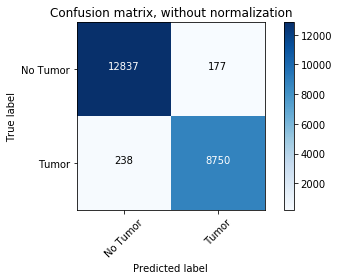

In [12]:
# Names of predicted classes
classes_names = ['No Tumor', 'Tumor']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes_names,
                      title='Confusion matrix, without normalization')

plt.show()

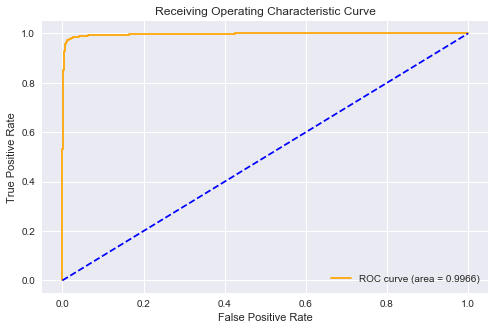

In [13]:
# Compute the ROC Curve of the ensemble
fpr, tpr, _ = roc_curve(target, avg_preds, pos_label=1)

# Plot the ROC Curve
plt.style.use('seaborn')
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.4f)' % ensemble_auc_score)
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.title('Receiving Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Store the results in a csv file
results = pd.DataFrame({
    'Neural Network' : ['DenseNet169', 'DenseNet201', 'ResNet101', 'ResNet50', 'Ensemble (Average)'],
    'AUC (%)' : [auc_scores[0], auc_scores[1], auc_scores[2], auc_scores[3], round(ensemble_auc_score, 4)],
    'Sensitivity (%)' : [sensitivity_scores[0], sensitivity_scores[1], sensitivity_scores[2], 
                     sensitivity_scores[3], round(ensemble_sensitivity_score, 4)
                    ],
    'Specificity (%)' : [specificity_scores[0], specificity_scores[1], specificity_scores[2], 
                     specificity_scores[3], round(ensemble_specificity_score, 4)
                    ]
    
})

results.set_index('Neural Network', drop=True, inplace=True)

In [15]:
results = 100*results
results.to_csv('results.csv')

In [16]:
results

,AUC (%),Sensitivity (%),Specificity (%)
Neural Network,,,
DenseNet169,99.57,97.02,97.96
DenseNet201,99.55,96.91,98.09
ResNet101,99.53,96.93,97.73
ResNet50,99.49,96.34,98.26
Ensemble (Average),99.66,97.35,98.64
